In [2]:
import pandas as pd
import numpy as np
import re
import spacy
nlp = spacy.load('en_core_web_sm')
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import torch
from sklearn.metrics import accuracy_score,f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier as DC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.svm import SVC

In [3]:
df = pd.read_csv("Corona_NLP_train.csv",engine='python',encoding='ISO-8859-1')
df['labels']=df['Sentiment'].map({'Extremely Negative':'negative','Negative':'negative','Neutral':'neutral',
                                                       'Positive':'positive','Extremely Positive':'positive'})
sample1  = df[df['labels']=='neutral'].sample(n=2300)
sample2 = df[df['labels']=='positive'].sample(n=3700)
sample3 = df[df['labels']=='negative'].sample(n=3000)
token_data = pd.concat([sample1,sample2,sample3],ignore_index=True)
#token_data = df.sample(n=9000)
token_data['labels'].value_counts()

positive    3700
negative    3000
neutral     2300
Name: labels, dtype: int64

In [120]:
def tokenize(tweets):
    tokens = []
    text = nlp(tweets)
    for t in text:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens
replacer ={r'#[^\s]+\W?':' ',r'@[^\s]+\W?':' ','\n':' ','http\S+':'','\r':'',r'[#()\[\]]':'',r'[""'':;.|!$%^&*=\-\+\d\\\/\?\`~><,]+':''}
#first removing all the usernames from the tweet as it is irrelevant and will only create extra vocabulary
print(token_data['OriginalTweet'].head(n=10))
#handling end of lines , and other symbols using replacer 
token_data['CleanTweet'] = token_data['OriginalTweet'].replace(replacer,regex=True)
#using regex to remove all non-asci characters.
token_data['CleanTweet']=token_data['CleanTweet'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
new_col = []
for tweet in tqdm(token_data['CleanTweet']):
    new_col.append(tokenize(tweet))
token_data['tokens'] = new_col
token_data.sample(n=5)

0    @jfahmy I feel so sick!  I think IÂll drive a...
1    UPDATED: Commissioner Nikki Fried Activates Ch...
2    There are people who stock up with food and to...
3    I work in retail where people come in and out ...
4    Southern #Nevada Home Prices Hit New Record #L...
5    COVID-19 is starting to take a deadly toll on ...
6    Is there not a strategic reserve supply of #to...
7    Anyone out there already sick of #pasta?\r\r\n...
8    @lisekimhorton This article says there are fiv...
9    Some of us are going to be in this boat soon ?...
Name: OriginalTweet, dtype: object


100%|██████████████████████████████████████████████████████████████████████████████| 9000/9000 [03:04<00:00, 48.77it/s]


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,labels,CleanTweet,tokens
2085,10809,55761,Central London UK,19-03-2020,All #supermarket trollies and baskets need to ...,Neutral,neutral,All trollies and baskets need to be cleaned r...,"[trollie, basket, need, clean, regularly, long..."
1522,28037,72989,"Princeton, NJ",26-03-2020,Online food and grocery sales have jumped 186%...,Neutral,neutral,Online food and grocery sales have jumped ove...,"[online, food, grocery, sale, jump, week, late..."
4480,13169,58121,NaN,20-03-2020,@skytv @SkyHelpTeam Did you seriously think it...,Extremely Positive,positive,Did you seriously think its a good idea to s...,"[seriously, think, good, idea, start, increase..."
4577,43139,88091,South Africa,12-04-2020,A healthy immune system will fight off #corona...,Extremely Positive,positive,A healthy immune system will fight off just l...,"[healthy, immune, system, fight, like, flu, re..."
5787,43802,88754,NaN,13-04-2020,With people working from home protecting yours...,Extremely Positive,positive,With people working from home protecting yours...,"[people, work, home, protect, network, importa..."


In [ ]:
def make_vocab(token_list):
    tokens = sorted(set(tok for token in token_list for tok in token))
    vocab = {v:k for k,v in enumerate(tokens)}
    return vocab
vocab = make_vocab(new_col)
print(len(vocab))
print(vocab)

13543
{'aaa': 0, 'aantal': 1, 'aap': 2, 'aapi': 3, 'aapl': 4, 'aaron': 5, 'ab': 6, 'abandon': 7, 'abandonment': 8, 'abass': 9, 'abate': 10, 'abattoir': 11, 'abbott': 12, 'abbreviation': 13, 'abc': 14, 'abce': 15, 'abd': 16, 'abdijan': 17, 'abdul': 18, 'abeg': 19, 'aberdeen': 20, 'abide': 21, 'ability': 22, 'abilty': 23, 'able': 24, 'abnormal': 25, 'aboard': 26, 'abode': 27, 'abou': 28, 'abound': 29, 'abourezk': 30, 'aboutturn': 31, 'abreast': 32, 'abroad': 33, 'abrupt': 34, 'absence': 35, 'absent': 36, 'absolute': 37, 'absolutely': 38, 'absorb': 39, 'absurd': 40, 'absynth': 41, 'abt': 42, 'abta': 43, 'abu': 44, 'abuja': 45, 'abundance': 46, 'abundant': 47, 'abuse': 48, 'abuser': 49, 'ac': 50, 'academy': 51, 'accc': 52, 'acce': 53, 'accelerant': 54, 'accelerate': 55, 'accelerator': 56, 'accept': 57, 'acceptable': 58, 'access': 59, 'accessible': 60, 'accessory': 61, 'accident': 62, 'accidental': 63, 'accidentally': 64, 'accidently': 65, 'accomadation': 66, 'accommodate': 67, 'accommodati

(9000, 13508)
(5, 13508)


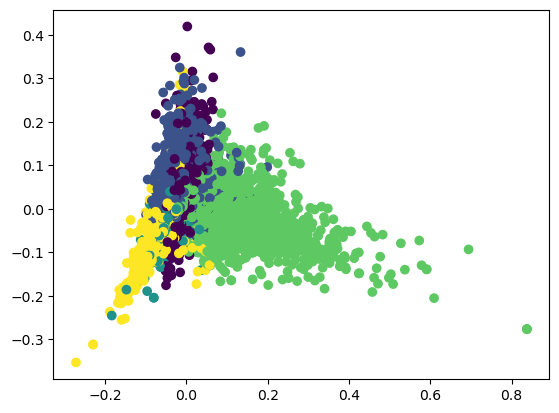

In [ ]:
def cosine_similarity_fn(doc, centroid):
    """
    Calculate the cosine similarity between two vectors.
    """
    norm_doc = np.linalg.norm(doc)
    norm_centroid = np.linalg.norm(centroid)
    if norm_doc == 0 or norm_centroid == 0:
        return 0
    else:
        return np.dot(doc, centroid)/ (norm_doc * norm_centroid)

# Convert the list of tokens into a TF-IDF matrix
vectorizer = TfidfVectorizer()
X_train_test = vectorizer.fit_transform(token_data['tokens'].apply(lambda x: ' '.join(x))).toarray()
print(X_train_test.shape)
# Define the number of clusters
k_clusters = 5

# Initialize the centroids randomly
new_centroids = X_train_test[np.random.choice(range(len(X_train_test)), k_clusters, replace=False)]
print(new_centroids.shape)
# Set the maximum number of iterations and the convergence tolerance
max_iterations = 100
convergence_tolerance = 0.001

# Perform K-means clustering using cosine similarity as the distance metric
for iteration in range(max_iterations):
    # Assign each document to the closest centroid based on cosine similarity
    similarities = np.apply_along_axis(cosine_similarity_fn, 1, X_train_test, new_centroids.T)
    clusters = np.argmax(similarities, axis=1)

    # Update the centroids based on the mean of the documents in each cluster
    updated_centroids = new_centroids.copy()
    for k in range(k_clusters):
        clustered_docs = X_train_test[clusters == k]
        if len(clustered_docs) > 0:
            new_centroids[k] = np.mean(clustered_docs, axis=0)

    # Check for convergence
    if np.sqrt(((new_centroids - updated_centroids)**2).sum(axis=1)).max() < convergence_tolerance:
        break
# Use PCA to project the documents into two dimensions for visualization
pca = PCA(n_components=2)
pc1, pc2 = pca.fit_transform(X_train_test).T

# Plot the clusters
plt.scatter(pc1, pc2, c=clusters)
plt.show()

In [ ]:
#Top 3 Original tweet documents for each cluster and top 5 tokens for each centroid
features = vectorizer.get_feature_names_out()
for i in range(5):
    cluster_docs = token_data.loc[clusters == i]["OriginalTweet"]
    print("Cluster "+str(i))
    for doc in cluster_docs.iloc[:3]:
        print("----" + doc,end='\n')
    print("\n")
    print(f"Top 5 tokens for cluster {i} are:",end='\n')
    cluster_centre = updated_centroids[i]
    top_features = cluster_centre.argsort()[-5:][::-1]
    print([features[index] for index in top_features])
    print("--------------------------------------------------------------------")

Cluster 0


#animal #animals #cats #cat #coronavirus #ThursdayThoughts #ThursdayMotivation #thursdayvibes https://t.co/7TnKJwBzAD

https://t.co/txGYCCH20s https://t.co/8bHHoAYNbk
----Today I needed bread, so I went to the supermarket. I didn't get a trolley. I didnt get a basket. Because I needed bread. Just bread. #StopPanicBuying #coronavirus #COVID19 #covid19UK


Top 5 tokens for cluster 0 are:
['supermarket', 'online', 'sanitizer', 'hand', 'shopping']
--------------------------------------------------------------------
Cluster 1
----@nikkig60 @PeterDevonUK Had the same experience yesterday. Shoppers barging past, leaning over. I wasnÂt loitering either.   WeÂre all in a rush but keep your distance people.
----This quarantine ainÂt it chief?? #bowl #bowling #DV8 #outcast #QuarantineDiaries #QuarantineLife #coronavirus #Covid_19  #virus #outside #toiletpaper #tiktok #bored #boredathome #gaming #gamer #pba #pbatour #pro #missed #messenger #24hours #2weeks  #Wow https://t.co/yo8odNz

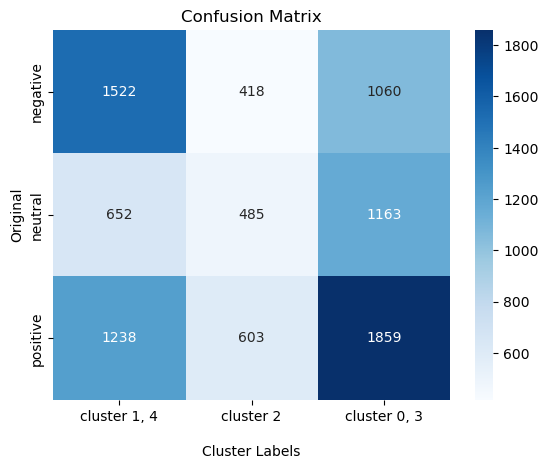

In [ ]:
#confusion matrix between clusters and target labels
''''there are total 5 labels given extremely positive , positive, neutral , negative, extremely negative
which can be converted to positive , neutral and negative
'''
mapper = {0:'positive', 1:'negative', 2:'neutral', 3:'positive', 4:'negative'}
mapped_cluster = np.array([mapper[val] for val in clusters])
y_true = np.array(token_data['labels'])
y_pred = mapped_cluster
cf_matrix = confusion_matrix(y_true,y_pred)
labelY = ['negative', 'neutral' , 'positive']
labelX = ['cluster 1, 4','cluster 2','cluster 0, 3']
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labelX, yticklabels=labelY)
plt.xlabel('\nCluster Labels')
plt.ylabel('Original')
plt.title('Confusion Matrix')
plt.show()

In [4]:
X_train,X_val_test,Y_train,Y_val_test = train_test_split(token_data,token_data['labels'],test_size=0.4,random_state=43)
X_val,X_test,Y_val,Y_test = train_test_split(X_val_test,Y_val_test,test_size=0.5)

In [5]:
X_train['labels'].value_counts()

positive    2224
negative    1766
neutral     1410
Name: labels, dtype: int64

In [7]:
X_val['labels'].value_counts()

positive    732
negative    616
neutral     452
Name: labels, dtype: int64

In [6]:
X_test['labels'].value_counts()

positive    744
negative    618
neutral     438
Name: labels, dtype: int64

In [15]:
vec = TfidfVectorizer()
Y_train = LE().fit_transform(Y_train)
Y_val = LE().fit_transform(Y_val)
Y_test =LE().fit_transform(Y_test)
X_train_1 = vec.fit_transform(X_train['tokens'].apply(lambda x: ' '.join(x)))
X_val_1 = vec.transform(X_val['tokens'].apply(lambda x: ' '.join(x)))

In [ ]:
DC_freq = DC(strategy="most_frequent").fit(X_train,Y_train)

print("                      On Training Data\n")
Y_pred_freq_train = DC_freq.predict(X_train_1)
print(classification_report(Y_pred_freq_train,Y_train,zero_division=True,digits=3))
print("-----------------------------------\n                     On Validation Data\n")
Y_pred_freq = DC_freq.predict(X_val_1)
print(classification_report(Y_pred_freq,Y_val,zero_division=True,digits=3))

                      On Training Data

              precision    recall  f1-score   support

           0      0.000     1.000     0.000         0
           1      0.000     1.000     0.000         0
           2      1.000     0.412     0.583      5400

    accuracy                          0.412      5400
   macro avg      0.333     0.804     0.194      5400
weighted avg      1.000     0.412     0.583      5400

-----------------------------------
                     On Validation Data

              precision    recall  f1-score   support

           0      0.000     1.000     0.000         0
           1      0.000     1.000     0.000         0
           2      1.000     0.408     0.579      1800

    accuracy                          0.408      1800
   macro avg      0.333     0.803     0.193      1800
weighted avg      1.000     0.408     0.579      1800



In [ ]:
DC_strat = DC(strategy='stratified').fit(X_train,Y_train)
print("                      On Training Data\n")
Y_pred_strat_train = DC_strat.predict(X_train_1)
print(classification_report(Y_pred_strat_train,Y_train,zero_division=True,digits=3))
print("-----------------------------------\n                     On Validation Data\n")
Y_test_strat = DC_strat.predict(X_val_1)
print(classification_report(Y_test_strat,Y_val,digits=3))

                      On Training Data

              precision    recall  f1-score   support

           0      0.342     0.335     0.338      1804
           1      0.263     0.267     0.265      1390
           2      0.405     0.408     0.406      2206

    accuracy                          0.347      5400
   macro avg      0.337     0.337     0.337      5400
weighted avg      0.347     0.347     0.347      5400

-----------------------------------
                     On Validation Data

              precision    recall  f1-score   support

           0      0.338     0.364     0.350       591
           1      0.291     0.269     0.280       464
           2      0.409     0.403     0.406       745

    accuracy                          0.356      1800
   macro avg      0.346     0.345     0.345      1800
weighted avg      0.355     0.356     0.355      1800



In [ ]:
lr = LogisticRegression(max_iter=10000)
log_model = lr.fit(X_train_1,Y_train)
print("                      On Training Data\n")
Y_pred_log_train = log_model.predict(X_train_1)
print(classification_report(Y_pred_log_train,Y_train,digits=3))
print("-----------------------------------\n                     On Validation Data\n")
Y_log = log_model.predict(X_val_1)
print(classification_report(Y_log,Y_val,digits=3))

                      On Training Data

              precision    recall  f1-score   support

           0      0.899     0.925     0.912      1715
           1      0.855     0.925     0.888      1303
           2      0.953     0.890     0.921      2382

    accuracy                          0.910      5400
   macro avg      0.902     0.913     0.907      5400
weighted avg      0.912     0.910     0.910      5400

-----------------------------------
                     On Validation Data

              precision    recall  f1-score   support

           0      0.691     0.726     0.708       606
           1      0.517     0.665     0.582       334
           2      0.815     0.695     0.750       860

    accuracy                          0.700      1800
   macro avg      0.674     0.695     0.680      1800
weighted avg      0.718     0.700     0.705      1800



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
one_hot = CountVectorizer(binary=True)
X_train_2 = one_hot.fit_transform(X_train['tokens'].apply(lambda x: ' '.join(x)))
X_val_2 = one_hot.transform(X_val['tokens'].apply(lambda x: ' '.join(x)))
log_one_hot = lr.fit(X_train_2,Y_train)
print("                      On Training Data\n")
Y_pred_log1_train = log_one_hot.predict(X_train_2)
print(classification_report(Y_pred_log1_train,Y_train,digits=3))
print("-----------------------------------\n                     On Validation Data\n")
Y_one_hot = log_one_hot.predict(X_val_2)
print(classification_report(Y_one_hot,Y_val,digits=3))

                      On Training Data

              precision    recall  f1-score   support

           0      0.976     0.983     0.980      1754
           1      0.982     0.965     0.973      1434
           2      0.981     0.986     0.984      2212

    accuracy                          0.980      5400
   macro avg      0.980     0.978     0.979      5400
weighted avg      0.980     0.980     0.980      5400

-----------------------------------
                     On Validation Data

              precision    recall  f1-score   support

           0      0.662     0.763     0.709       553
           1      0.737     0.628     0.678       503
           2      0.762     0.751     0.756       744

    accuracy                          0.721      1800
   macro avg      0.720     0.714     0.715      1800
weighted avg      0.724     0.721     0.720      1800



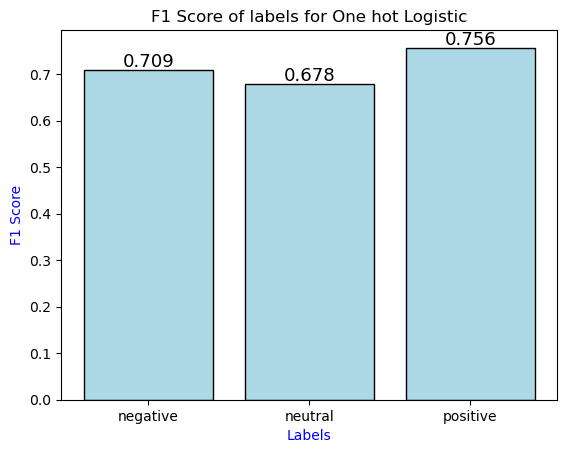

In [ ]:
f1_log = f1_score(Y_one_hot,Y_val,average=None)
fig, ax = plt.subplots()
ax.bar(np.arange(3), f1_log, tick_label=labelY, color='lightblue',ec='k')
for i, j in enumerate(f1_log):
    ax.text(i, j+0.018, str(round(j,3)), color='k', ha='center', va='center',fontsize = 13)
ax.set_ylabel("F1 Score", color='b')
ax.set_xlabel('Labels', color='b')
ax.set_title("F1 Score of labels for One hot Logistic")
plt.show()

In [ ]:
svc_clf1 = SVC()
svc_one_hot = svc_clf1.fit(X_train_2,Y_train)
print("                      On Training Data\n")
Y_pred_svc_train = svc_one_hot.predict(X_train_2)
print(classification_report(Y_pred_svc_train,Y_train,digits=3))
print("-----------------------------------\n                     On Validation Data\n")
Y_svc_hot = svc_one_hot.predict(X_val_2)
print(classification_report(Y_svc_hot,Y_val,digits=3))

                      On Training Data

              precision    recall  f1-score   support

           0      0.926     0.977     0.951      1673
           1      0.951     0.865     0.906      1551
           2      0.943     0.964     0.953      2176

    accuracy                          0.939      5400
   macro avg      0.940     0.935     0.937      5400
weighted avg      0.940     0.939     0.939      5400

-----------------------------------
                     On Validation Data

              precision    recall  f1-score   support

           0      0.589     0.740     0.656       507
           1      0.690     0.597     0.640       496
           2      0.751     0.691     0.720       797

    accuracy                          0.679      1800
   macro avg      0.676     0.676     0.672      1800
weighted avg      0.688     0.679     0.680      1800



In [ ]:
from sklearn.svm import LinearSVC
svc_clf2 = LinearSVC(penalty = 'l1',C=1,dual =False)
svc_model = svc_clf2.fit(X_train_1,Y_train)
print("                      On Training Data\n")
Y_svc_train = svc_model.predict(X_train_1)
print(classification_report(Y_svc_train,Y_train,digits=3))
print("-----------------------------------\n                     On Validation Data\n")
Y_svc = svc_model.predict(X_val_1)
print(classification_report(Y_svc,Y_val,digits=3))

                      On Training Data

              precision    recall  f1-score   support

           0      0.921     0.943     0.932      1725
           1      0.940     0.923     0.931      1436
           2      0.945     0.939     0.942      2239

    accuracy                          0.936      5400
   macro avg      0.935     0.935     0.935      5400
weighted avg      0.936     0.936     0.936      5400

-----------------------------------
                     On Validation Data

              precision    recall  f1-score   support

           0      0.703     0.790     0.744       567
           1      0.716     0.663     0.688       463
           2      0.812     0.774     0.793       770

    accuracy                          0.751      1800
   macro avg      0.744     0.742     0.742      1800
weighted avg      0.753     0.751     0.751      1800



In [ ]:
tfidf = TfidfVectorizer(min_df= 5,ngram_range=(1,3),sublinear_tf=True,max_features=8000)
X_train_3 = tfidf.fit_transform(X_train['tokens'].apply(lambda x: ' '.join(x)))
X_val_3 = tfidf.transform(X_val['tokens'].apply(lambda x: ' '.join(x)))
tuned_lr = LogisticRegression(C=1.7,solver='saga',penalty='l1',max_iter=10000)
tuned_lr.fit(X_train_3,Y_train)
Y_tuned_lr = tuned_lr.predict(X_val_3)
print("-----------------------------------\n                     On Validation Data\n")
print(classification_report(Y_tuned_lr,Y_val,digits=3))
print("                      On Training Data\n")
Y_pred_training = tuned_lr.predict(X_train_3)
print(classification_report(Y_pred_training,Y_train,digits=3))

-----------------------------------
                     On Validation Data

              precision    recall  f1-score   support

           0      0.688     0.768     0.726       570
           1      0.727     0.654     0.689       477
           2      0.808     0.788     0.798       753

    accuracy                          0.746      1800
   macro avg      0.741     0.737     0.737      1800
weighted avg      0.748     0.746     0.746      1800

                      On Training Data

              precision    recall  f1-score   support

           0      0.804     0.868     0.835      1634
           1      0.865     0.786     0.823      1553
           2      0.870     0.874     0.872      2213

    accuracy                          0.847      5400
   macro avg      0.846     0.843     0.843      5400
weighted avg      0.849     0.847     0.847      5400



In [7]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install transformers

from transformers import pipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.1 MB/s eta 0:00:00


In [122]:
tokenizer = pipeline('feature-extraction', model='roberta-base')
X_train_enc = tokenizer(X_train['CleanTweet'].tolist(),truncation=True,padding=True,max_length=100)
X_val_enc = tokenizer(X_val['CleanTweet'].tolist(),truncation=True,padding=True,max_length=100)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_CLS = np.array([enc[0][0] for enc in X_train_enc])
val_CLS = np.array([enc[0][0] for enc in X_val_enc])
cv_lr = lr.fit(train_CLS,Y_train)
print("                      On Training Data\n")
Y_pred_cv = cv_lr.predict(train_CLS)
print(classification_report(Y_pred_cv,Y_train,digits=3))
Y_vector = cv_lr.predict(val_CLS)
print("-----------------------------------\n                     On Validation Data\n")
print(classification_report(Y_vector,Y_val,digits=3))

                      On Training Data

              precision    recall  f1-score   support

           0      0.633     0.659     0.646      1697
           1      0.591     0.653     0.621      1278
           2      0.722     0.662     0.690      2425

    accuracy                          0.659      5400
   macro avg      0.649     0.658     0.652      5400
weighted avg      0.663     0.659     0.660      5400

-----------------------------------
                     On Validation Data

              precision    recall  f1-score   support

           0      0.612     0.640     0.626       609
           1      0.534     0.577     0.554       397
           2      0.672     0.621     0.645       794

    accuracy                          0.618      1800
   macro avg      0.606     0.613     0.609      1800
weighted avg      0.621     0.618     0.619      1800



In [10]:
from transformers import pipeline
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from transformers import AdamW
import torch

In [11]:
tokenizer_trainer = RobertaTokenizer.from_pretrained('roberta-base',num_labels=3)
X_train_tr = tokenizer_trainer.batch_encode_plus(X_train['CleanTweet'].tolist(),truncation=True,padding=True,max_length=128,
                                               return_tensors='pt',return_attention_mask=True)
X_val_tr = tokenizer_trainer.batch_encode_plus(X_val['CleanTweet'].tolist(),truncation=True,padding=True,max_length=128,
                                              return_tensors='pt',return_attention_mask=True)

In [32]:
Y_train_tr = torch.tensor(Y_train)
Y_val_tr = torch.tensor(Y_val)
Y_test_tr = torch.tensor(Y_test)
Y_train_tr = Y_train_tr.type(torch.LongTensor)
Y_val_tr = Y_val_tr.type(torch.LongTensor)
Y_test_tr = Y_test_tr.type(torch.LongTensor)

In [17]:
#Convert the input and output tensors to PyTorch datasets
from torch.utils.data import DataLoader, TensorDataset
batch_size=16
train_data = TensorDataset(X_train_tr.input_ids, X_train_tr.attention_mask, Y_train_tr)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(X_val_tr.input_ids, X_val_tr.attention_mask, Y_val_tr)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [20]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

In [22]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base',num_labels=3)
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [ ]:
from sklearn.metrics import accuracy_score

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=lambda data: {'input_ids': torch.stack([item[0] for item in data]),
                                'attention_mask': torch.stack([item[1] for item in data]),
                                'labels': torch.tensor([item[2] for item in data])},
    compute_metrics=lambda pred: {"accuracy": accuracy_score(pred.label_ids, pred.predictions.argmax(-1))}
    
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.606786,0.770556


TrainOutput(global_step=338, training_loss=0.8378112612391365, metrics={'train_runtime': 112.374, 'train_samples_per_second': 48.054, 'train_steps_per_second': 3.008, 'total_flos': 285827505742800.0, 'train_loss': 0.8378112612391365, 'epoch': 1.0})

In [28]:
print("                      On Training Data\n")
bert_pred = trainer.predict(train_data)
Y_bert = bert_pred.predictions.argmax(-1)
print(classification_report(Y_bert,Y_train,digits=3))
print("-----------------------------------\n                     On Validation Data\n")
pred = trainer.predict(val_data)
Y_pred = pred.predictions.argmax(-1)
print(classification_report(Y_pred,Y_val,digits=3))

                      On Training Data



              precision    recall  f1-score   support

           0      0.854     0.797     0.824      1892
           1      0.757     0.846     0.799      1262
           2      0.838     0.830     0.834      2246

    accuracy                          0.822      5400
   macro avg      0.816     0.824     0.819      5400
weighted avg      0.825     0.822     0.823      5400

-----------------------------------
                     On Validation Data



              precision    recall  f1-score   support

           0      0.797     0.762     0.779       650
           1      0.668     0.766     0.714       384
           2      0.809     0.781     0.795       766

    accuracy                          0.771      1800
   macro avg      0.758     0.769     0.762      1800
weighted avg      0.775     0.771     0.772      1800



In [37]:
#Bert tuning
training_args_tuned = TrainingArguments(
    output_dir='./results',
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    evaluation_strategy='epoch',
    save_strategy='epoch'
)


In [39]:
trainer = Trainer(
    model=model,
    args=training_args_tuned,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=lambda data: {'input_ids': torch.stack([item[0] for item in data]),
                                'attention_mask': torch.stack([item[1] for item in data]),
                                'labels': torch.tensor([item[2] for item in data])},
    compute_metrics=lambda pred: {"accuracy": accuracy_score(pred.label_ids, pred.predictions.argmax(-1))}
    
)
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.885680,0.792222
2,No log,0.850942,0.800000
3,0.185700,0.885867,0.810556


TrainOutput(global_step=507, training_loss=0.18557659926028883, metrics={'train_runtime': 310.5406, 'train_samples_per_second': 52.167, 'train_steps_per_second': 1.633, 'total_flos': 857482517228400.0, 'train_loss': 0.18557659926028883, 'epoch': 3.0})

In [35]:
print("                      On Training Data\n")
bert_pred = trainer.predict(train_data)
Y_bert = bert_pred.predictions.argmax(-1)
print(classification_report(Y_bert,Y_train,digits=3))
print("-----------------------------------\n                     On Validation Data\n")
pred = trainer.predict(val_data)
Y_pred = pred.predictions.argmax(-1)
print(classification_report(Y_pred,Y_val,digits=3))

                      On Training Data



              precision    recall  f1-score   support

           0      0.987     0.937     0.961      1861
           1      0.896     0.972     0.932      1299
           2      0.970     0.963     0.967      2240

    accuracy                          0.956      5400
   macro avg      0.951     0.957     0.953      5400
weighted avg      0.958     0.956     0.957      5400

-----------------------------------
                     On Validation Data



              precision    recall  f1-score   support

           0      0.831     0.802     0.816       643
           1      0.766     0.826     0.795       408
           2      0.846     0.834     0.840       749

    accuracy                          0.821      1800
   macro avg      0.814     0.821     0.817      1800
weighted avg      0.822     0.821     0.821      1800



In [36]:
print("                    Best Model BERT On Test Data")
X_test_tr = tokenizer_trainer.batch_encode_plus(X_test['CleanTweet'].tolist(),truncation=True,padding=True,max_length=128,
                                              return_tensors='pt',return_attention_mask=True)
test_data = TensorDataset(X_test_tr.input_ids, X_test_tr.attention_mask, Y_test_tr)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
pred_test =  trainer.predict(test_data)
Y_test_pred = pred_test.predictions.argmax(-1)
print(classification_report(Y_test_pred,Y_test,digits=3))

                    Best Model BERT On Test Data


              precision    recall  f1-score   support

           0      0.858     0.822     0.840       640
           1      0.762     0.862     0.809       398
           2      0.862     0.833     0.847       762

    accuracy                          0.836      1800
   macro avg      0.827     0.839     0.832      1800
weighted avg      0.838     0.836     0.836      1800



array(['positive', 'negative', 'neutral'], dtype=object)

In [109]:
manual_df = X_test[['OriginalTweet','Sentiment','labels']]
manual_df['Predicted'] = Y_test_pred
manual_df.sample(n=10)

<ipython-input-109-1bd0e3906319>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_df['Predicted'] = Y_test_pred


,OriginalTweet,Sentiment,labels,Predicted
7563,"@kmoxnews I am not the ""get-off-my-lawn guy,"" ...",Extremely Negative,negative,0
3252,Our partners at @NetElixir are using their kno...,Positive,positive,2
7966,Michigan farmers fear ruin as coronavirus lock...,Extremely Negative,negative,0
2266,Wondering what impact Covid-19 is having on on...,Neutral,neutral,1
2921,Imagine there's no loo roll\r\r\nIt's easy if ...,Extremely Positive,positive,2
365,Tuskys partners with Amref to provide on groun...,Neutral,neutral,1
5515,We canÂt thank them enough!! #nhs #nurses #do...,Positive,positive,2
5480,In light of DARE America is pulling employees ...,Extremely Positive,positive,2
6066,"Antibac handwash like gold dust in shops, but ...",Negative,negative,2
1378,Another PSA supermarket edition: please stop b...,Neutral,neutral,0


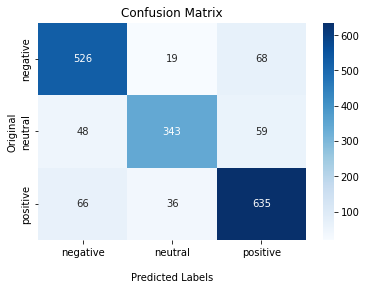

In [91]:
cm_mat = confusion_matrix(LE().fit_transform(manual_df['labels']), manual_df['Predicted'])

# plot the confusion matrix
sns.heatmap(cm_mat, annot=True, cmap='Blues', fmt='g', xticklabels=labelY, yticklabels=labelY)
plt.xlabel('\nPredicted Labels')
plt.ylabel('Original')
plt.title('Confusion Matrix')
plt.show()